# CS 4E03 Energy System Research Project 2

<b>Author</b>: Jingze Dai, McMaster University
<br>
<b>Research Supervisor</b>: Dr.Douglas Down, Department of Computing and Software, McMaster University

<a name="toc"></a>
## Table of Contents
* [Section 1: Summary of Section Structures](#first-bullet)
* [Section 2: Simulation Code](#second-bullet)
* [Section 3: Extra Statistical Programs](#third-bullet)
  * [Subsection 3.1: Calculate the expected number of jobs](#sbs3-1)
  * [Subsection 3.2: Calculate the sum of all OFF and ON states' steady-state probability](#sbs3-2)
  * [Subsection 3.3: Calculate the sum of all idle and non-idle states](#sbs3-3)
  * [Subsection 3.4: Rendering a simplified transition diagram (when max_jobs = 5)](#sbs3-4)
  * [Subsection 3.5: Customized total cost functions](#sbs3-5)
* [Section 4: Programs to find the optimized parameters (with the minimal total cost)](#bullet4)
  * [Subsection 4.1: Binary search when the arrival rate = 1 to 500](#sbs4-1)
    * [Subsection 4.1.1: Sub-section 4.1 Results' Visualization](#sbss4-1-1)

<a class="anchor" id="first-bullet"><h3><b>Section 1</b>: Summary of Section Structures</h3></a> 
<br>
[Back to Menu](#toc)

<b>Section 1</b>: Summary of Section Structures
<ul>
  <li><b>This Section</b></li>
  <li>Introduces each section's main contents, for a better understanding of readers.</li>
</ul>

<b>Section 2</b>: Simulation Code
<ul>
  <li><b>Main body of the simulated model of energy systems</b></li>
  <li><i>Step 1</i>: Construct a CTMC with given parameters.</li>
  <li><i>Step 2</i>: Compute all states' steady-state probability.</li>
  <li><i>Step 3</i>: Compute the whole system's energy consumption cost.</li>
  <li><i>Step 4</i>: Compute the whole system's total cost.</li>
</ul>

<b>Section 3</b>: Extra Statistical Programs
<ul>
  <li>Supplemental helpful programs for diverse calculations.</li>
</ul>

<b>Section 4</b>: Programs to find the optimized parameters (with the minimal cost)
<ul>
  <li>Grid search programs to determine the optimal parameter group with the minimized total cost.</li>
</ul>

<a class="anchor" id="second-bullet"><h3><b>Section 2</b>: Simulation Code</h3></a> 
<br>
[Back to Menu](#toc)

In [40]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs
from scipy.linalg import solve
import time

# Count this program's running time
start_time = time.time()

def initialize_parameters():
    global arrival_rate, serve_rate, turnon_rate, idle_rate, idle_power_cost
    global k1, k2, will_turn_off
    global power_OFF_idle, power_OFF_on, power_ON_idle, power_ON_reg, power_ON_enhanced, beta
    
    """
    lambda - the arrival rate                                                       -> Constant
    mu     - the service rate                                                       -> Constant
    gamma  - the rate at which system turns on (turnon_rate)                        -> Constant
    alpha  - the rate at which system turns off with no tasks (idle_rate)           -> Constant
    sigma  - the power consumption in the idle state                                -> Constant
    """
    # To make the system stable, assume lambda < mu
    # The enhanced serve rate (lambda_bar) must be smaller than the normal serve rate
    # Both the turn on rate and the idle rate must be greater than 0
    arrival_rate = 0.2
    serve_rate = 1.0
    turnon_rate = 2.0
    idle_rate = 2.0
    idle_power_cost = 0.5

    """
    Threshold k1 - the amount of jobs triggering the energy system to turn on                          -> Variable
    The decision on whether the energy system will turn off once it becomes idle (True or False)       -> Variable
    """
    k1 = 1
    will_turn_off = False

    """
    Power consumption definitions
    Off states being idle (note serving any jobs): 0 power consumption               -> Constant
    Off states turning on: 1 power consumption                                       -> Constant
    On states being idle (note serving any jobs): 0.5 power consumption              -> Constant
    On states processing at regular rates: 1 power consumption                       -> Constant
    On states processing at enhanced rates: (enhanced rate) ^ 2 power consumption    -> Constant
    beta (Power consumption weights in the total cost calculation)                   -> Constant
    """
    power_OFF_idle = 0.0
    power_OFF_on = 1.0
    power_ON_idle = idle_power_cost
    power_ON_reg = serve_rate
    beta = 1

def setup_States():
    global max_jobs, states, n_states
    # States starting with "OFF" mean OFF, and states starting with "ON" mean ON
    # State name's number represents the amount of waiting jobs
    # e.g., State OFF_0 represents the system is off, and there is 0 job inside the system
    # Example: states = ['OFF_0', 'OFF_1', 'OFF_2', 'OFF_3', 'OFF_4', 'OFF_5', 'ON_0', 'ON_1', 'ON_2', 'ON_3', 'ON_4', 'ON_5']
    max_jobs = 500
    states = [f'OFF_{i}' for i in range(max_jobs + 1)] + [f'ON_{i}' for i in range(max_jobs + 1)]
    n_states = len(states)

# Exception Handling for discovering unexpected parameter values.
def exception_handling():
    # Part 1: Check whether constant parameters' values are in the appropriate range.
    if arrival_rate <= 0 or arrival_rate >= 1:
        raise Exception("Problem: Illegal arrival rate values")
    if serve_rate != 1:
        raise Exception("Problem: Illegal service rate values")
    if arrival_rate >= serve_rate:
        raise Exception("Problem: Unstable System: arrival rate > serving rate")
    if turnon_rate <= 0:
        raise Exception("Problem: Illegal turn-on rate values")
    if idle_rate <= 0:
        raise Exception("Problem: Illegal idle rate values")
    if idle_power_cost <= 0 or idle_power_cost >= 1:
        raise Exception("Problem: Illegal idle power cost values")    
    # Part 2: Check whether variable parameters' values are in the appropriate range.
    if not (1 <= k1 <= max_jobs):
        raise Exception("Problem: Illegal threshold k1 value")

# Construct the transition matrix for further computing
def setup_Transition_Matrix():
    global transition_matrix, transitions, state_indices, transition_df
    transition_matrix = np.zeros((n_states, n_states))
    transitions = {}

    # Adding transitions for all ON and OFF states
    for i in range(max_jobs):
        transitions[(f'OFF_{i}', f'OFF_{i + 1}')] = arrival_rate
        transitions[(f'ON_{i}', f'ON_{i + 1}')] = arrival_rate

    for i in range(k1, max_jobs + 1):
        transitions[(f'OFF_{i}', f'ON_{i}')] = turnon_rate

    for i in range(1, max_jobs + 1):
        transitions[(f'ON_{i}', f'ON_{i - 1}')] = serve_rate
    
    # The idle rate only works when the system determines to turn off
    # Otherwise, the system will not go back to state 'OFF_0'
    if will_turn_off is True:
        transitions[('ON_0', 'OFF_0')] = idle_rate
    
    state_indices = {state: i for i, state in enumerate(states)}
    for (from_state, to_state), rate in transitions.items():
        i, j = state_indices[from_state], state_indices[to_state]
        transition_matrix[i, j] = rate

    row_sums = transition_matrix.sum(axis=1)
    for i in range(n_states):
        transition_matrix[i, i] = -row_sums[i]

    # Convert to CSR format (or keep as a dense array if needed for other operations)
    transition_matrix = csr_matrix(transition_matrix)

    # Convert the sparse matrix to a dense array for DataFrame construction
    transition_df = pd.DataFrame(transition_matrix.toarray(), index=states, columns=states)

# Calculate each states' steady-state probability
def calculate_Steady_State(probabilityPrint=False, errorPrint=True):
    global steady_state_probs, steady_state_df, min_prob

    Q = transition_matrix.toarray().T
    Q[-1, :] = 1  # Replace the last equation with the normalization condition

    b = np.zeros(n_states)
    b[-1] = 1

    steady_state_probs = solve(Q, b)
    steady_state_df = pd.DataFrame(steady_state_probs, index=states, columns=["Probability"])

    # Checkes whether or not there are null and indefinite values 
    # Because null and infinite values are serious problems, we have to shut down running
    if np.any(np.isnan(steady_state_probs)) or np.any(np.isinf(steady_state_probs)):
        print("Error: Steady-state probabilities contain NaNs or infinities.")
        return

    # Print steady-state proability if required
    if probabilityPrint:
        print("Steady-State Probabilities:")
        print(steady_state_df)

    # Check the magnitude of negative steady-state probability values
    # If all negative values are too small, then it is OK
    min_prob = steady_state_df.min().values[0]
    if abs(min_prob) >= 1e-8 and min_prob < 0:
        if errorPrint:
            print(f"The minimum steady-state probability {min_prob} is significant.")
    elif errorPrint:
        print(f"The minimum steady-state probability {min_prob} approaches 0, can be ignored.")

    # Check the amount of negative steady-state probability values
    negative_indices = np.where(steady_state_probs < 0)[0]
    if len(negative_indices) > 0:
        if errorPrint:
            print(f"Warning: Found {len(negative_indices)} negative values in steady-state probabilities")
        # Optionally handle negative values here
    elif errorPrint:
        print("NO NEGATIVE steady-state probability values")

    # Check whether all steady-state probability values sum up to 1.
    sum_prob = steady_state_probs.sum()
    if not np.isclose(sum_prob, 1):
        if errorPrint:
            print(f"Warning: The sum of steady-state probabilities is {sum_prob}, which is not close to 1.")
    else:
        if errorPrint:
            print("Sum is 1, Good.")

# Power consumption calculations
# Example: State A has steady state probability 0.3, State B 0.5, and State C 0.2.
# State A power consumption 1, State B 2, and State C 3.
# Total energy consumption = 1 * 0.3 + 2 * 0.5 + 3 * 0.2 = 1.9. -> Suming up each state's power consumption.
def calculate_Power_Consumption():
    global power_consumption, power_consumption_sum, power_consumption_list
    power_consumption = {f'OFF_{i}': power_OFF_on if i >= k1 else power_OFF_idle for i in range(max_jobs + 1)}
    power_consumption.update({f'ON_{i}': power_ON_reg for i in range(max_jobs + 1)})
    power_consumption.update({'ON_0': power_ON_idle})

    # Compute each state's power consumption, and recording these values on a list
    power_consumption_list = np.array(
        [steady_state_probs[i] * power_consumption[states[i]] for i in range(len(steady_state_probs))])
    power_consumption_sum = np.sum(power_consumption_list) # Calculate the whole system's energy consumption
    
# Calculate Total Cost
def calculate_Cost(steady_state_df):
    global total_cost, expected_jobs
    probabilities = np.array(steady_state_df["Probability"].values)
    jobs = np.array([int(state.split('_')[1]) for state in steady_state_df.index])
    expected_jobs = np.dot(jobs, probabilities)

    # Formula: Total cost = total power consumption * the power consumption weights + expected number of jobs
    total_cost = power_consumption_sum * beta + expected_jobs

# Model Execution
initialize_parameters()
setup_States()
exception_handling()
setup_Transition_Matrix()
calculate_Steady_State(False, True)
calculate_Power_Consumption()
calculate_Cost(steady_state_df)

# Display various results below
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_colwidth', None)

print("\nTransition Matrix:")
print(transition_df)
print("\n")

print("\nSteady-State Probabilities:")
print(steady_state_df)
print("\n")

# Print out first 10 OFF states
print(steady_state_df.loc['OFF_0'])
print(steady_state_df.loc['OFF_1'])
print(steady_state_df.loc['OFF_2'])
print(steady_state_df.loc['OFF_3'])
print(steady_state_df.loc['OFF_4'])
print(steady_state_df.loc['OFF_5'])
print(steady_state_df.loc['OFF_6'])
print(steady_state_df.loc['OFF_7'])
print(steady_state_df.loc['OFF_8'])
print(steady_state_df.loc['OFF_9'])
print("\n")

# Print out first 10 ON states
print(steady_state_df.loc['ON_0'])
print(steady_state_df.loc['ON_1'])
print(steady_state_df.loc['ON_2'])
print(steady_state_df.loc['ON_3'])
print(steady_state_df.loc['ON_4'])
print(steady_state_df.loc['ON_5'])
print(steady_state_df.loc['ON_6'])
print(steady_state_df.loc['ON_7'])
print(steady_state_df.loc['ON_8'])
print(steady_state_df.loc['ON_9'])
print("\n")

print("\nIndividual-State Expected Power Consumption Values:")
print(power_consumption)

print("\nEach State's Actual Power Consumption (During Calculation):")
print(power_consumption_list)

print("\nTotal Power Consumption: " + str(power_consumption_sum))

print("\nTotal Cost: " + str(total_cost))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nCalculation time: {elapsed_time:.6f} seconds")

The minimum steady-state probability -1.2888468825106372e-15 approaches 0, can be ignored.
Sum is 1, Good.

Transition Matrix:
        OFF_0  OFF_1  OFF_2  OFF_3  OFF_4  OFF_5  OFF_6  OFF_7  OFF_8  OFF_9  \
OFF_0    -0.2    0.2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
OFF_1     0.0   -2.2    0.2    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
OFF_2     0.0    0.0   -2.2    0.2    0.0    0.0    0.0    0.0    0.0    0.0   
OFF_3     0.0    0.0    0.0   -2.2    0.2    0.0    0.0    0.0    0.0    0.0   
OFF_4     0.0    0.0    0.0    0.0   -2.2    0.2    0.0    0.0    0.0    0.0   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
ON_496    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
ON_497    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
ON_498    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
ON_499    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    

<a class="anchor" id="third-bullet"><h3><b>Section 3</b>: Extra Statistical Programs</h3></a> 
<br>
[Back to Menu](#toc)

<b>Reminder: Before running this section's programs, please run the section 2 simulation model first.</b>

<p><b><a class="anchor" id="sbs3-1">Function 1</a></b>: Calculate the expected number of jobs</p>

In [14]:
import numpy as np

start_time = time.time()

# Method: Multiply each state's steady-state probability with their corresponding numbers of jobs
def calculate_expected_jobs(steady_state_df):
    probabilities = np.array(steady_state_df["Probability"].values)
    jobs = np.array([int(state.split('_')[1]) for state in steady_state_df.index])
    expected_jobs = np.dot(jobs, probabilities)

    return expected_jobs

print(f"Expected Number of Jobs in the Energy System: {calculate_expected_jobs(steady_state_df):.6f}")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nCalculation time: {elapsed_time:.6f} seconds")

Expected Number of Jobs in the Energy System: 1.000000

Calculation time: 0.000512 seconds


<p><b><a class="anchor" id="sbs3-2">Function 2</a></b>: Calculate the sum of all OFF and ON states' steady-state probability</p>

In [13]:
# Find all ON and OFF states' sum of steady-state probability
off_states = [state for state in steady_state_df.index if state.startswith('OFF')]
on_states = [state for state in steady_state_df.index if state.startswith('ON')]

sum_off_states = steady_state_df.loc[off_states].sum().values[0]
sum_on_states = steady_state_df.loc[on_states].sum().values[0]

print(f"Sum of steady-state probabilities for all OFF states: {sum_off_states:.6f}")
print(f"Sum of steady-state probabilities for all ON states: {sum_on_states:.6f}")

Sum of steady-state probabilities for all OFF states: 0.000000
Sum of steady-state probabilities for all ON states: 1.000000


<p><b><a class="anchor" id="sbs3-3">Function 3</a></b>: Calculate the sum of all idle and non-idle states</p>

In [15]:
# Find all idle and non-idle states' sum of steady-state probability
idle_states = [state for state in steady_state_df.index if state.endswith('0')]
non_idle_states = [state for state in steady_state_df.index if not state.endswith('0')]

sum_idle_states = steady_state_df.loc[idle_states].sum().values[0]
sum_non_idle_states = steady_state_df.loc[non_idle_states].sum().values[0]

print(f"Sum of steady-state probabilities for all idle states: {sum_idle_states:.6f}")
print(f"Sum of steady-state probabilities for all non-idle states: {sum_non_idle_states:.6f}")

Sum of steady-state probabilities for all idle states: 0.500489
Sum of steady-state probabilities for all non-idle states: 0.499511


<p><b><a class="anchor" id="sbs3-4">Function 4</a></b>: Rendering a simplified transition diagram (when max_jobs = 5)</p>

In [20]:
# Enable plot interactivity
%matplotlib notebook

<IPython.core.display.Javascript object>


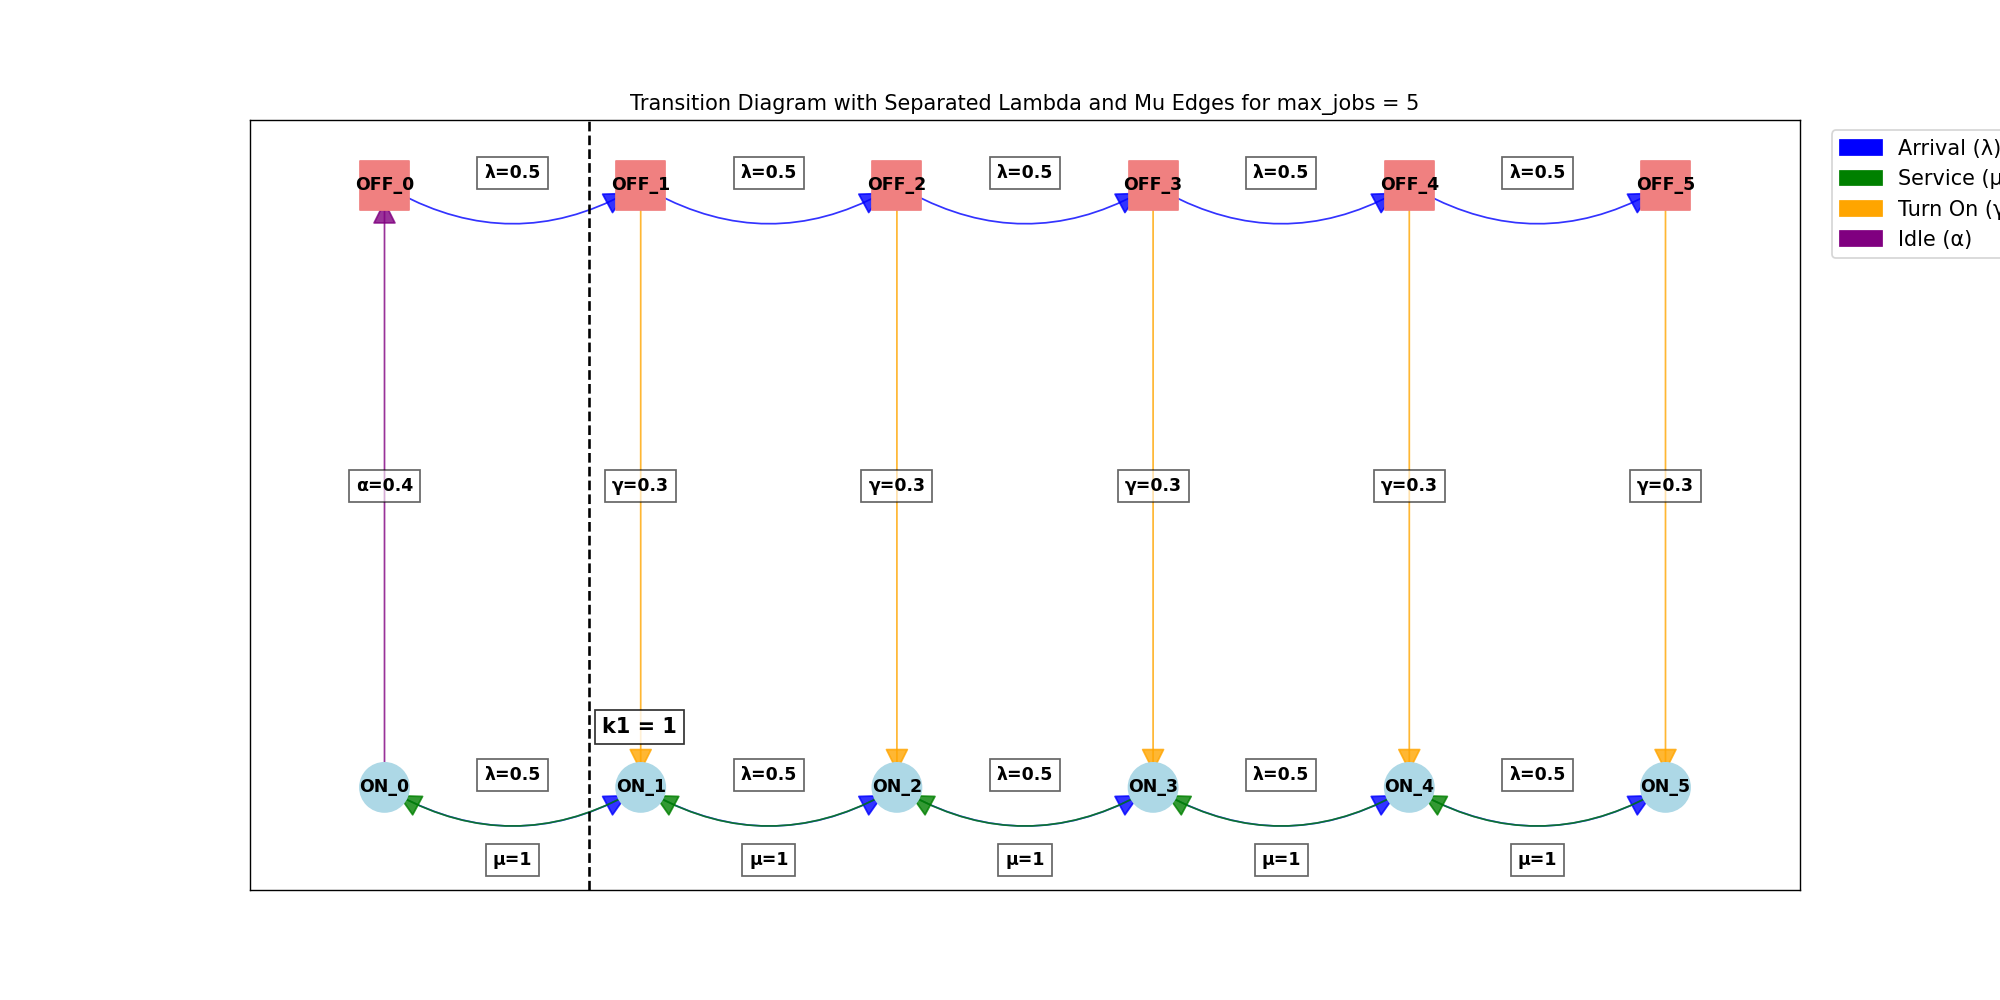

C:\Users\david\AppData\Local\Temp\ipykernel_9228\2432848344.py:73: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=service_edges, edge_color='green', arrowstyle='-|>',


In [22]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

'''
Generate a simplified model's transition diagram, with a maximum job capacity of 5 jobs.
(In realistic situations, the maximal job capacity should be infinite.)
1. 6 OFF states: OFF_0 to OFF_5, where the state OFF_0 is the OFF state.
2. 6 ON states: ON_0 to ON_5, where the state ON_0 is the IDLE state.
3. k1 = 2, so when there are >= 2 jobs in the system, the system will start to turn on.
4. k2 = 4, so when there are >= 4 jobs in the system, the system will switch to an enhanced service rate.
'''

def draw_transition_diagram_with_separated_edges(max_jobs=5):
    G = nx.DiGraph()
    
    arrival_rate = 0.5
    serve_rate = 1
    enhanced_serve_rate = 1.75
    turnon_rate = 0.3
    idle_rate = 0.4
    
    k2 = 4
    will_turn_off = True

    off_states = [f'OFF_{i}' for i in range(max_jobs + 1)]
    on_states = [f'ON_{i}' for i in range(max_jobs + 1)]
    
    for state in off_states:
        G.add_node(state, color='lightcoral', node_type='s')  # Square for OFF states

    for state in on_states:
        G.add_node(state, color='lightblue', node_type='o')  # Circle for ON states

    for i in range(max_jobs):
        G.add_edge(f'OFF_{i}', f'OFF_{i + 1}', label=f'λ={arrival_rate}', layer='arrival')
    
    for i in range(max_jobs):
        G.add_edge(f'ON_{i}', f'ON_{i + 1}', label=f'λ={arrival_rate}', layer='arrival')

    for i in range(1, max_jobs + 1):
        G.add_edge(f'OFF_{i}', f'ON_{i}', label=f'γ={turnon_rate}', layer='turnon')

    for i in range(1, max_jobs + 1):
        service_rate = serve_rate
        G.add_edge(f'ON_{i}', f'ON_{i - 1}', label=f'μ={service_rate}', layer='service')

    if will_turn_off:
        G.add_edge('ON_0', 'OFF_0', label=f'α={idle_rate}', layer='idle')

    pos = {}
    for i, state in enumerate(off_states):
        pos[state] = (i, 1)

    for i, state in enumerate(on_states):
        pos[state] = (i, 0)

    plt.figure(figsize=(16, 8))

    node_colors = [nx.get_node_attributes(G, 'color')[node] for node in G.nodes()]
    node_shapes = [nx.get_node_attributes(G, 'node_type')[node] for node in G.nodes()]
    
    for shape in set(node_shapes):
        nodelist = [node for node in G.nodes() if nx.get_node_attributes(G, 'node_type')[node] == shape]
        nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_shape=shape, 
                               node_color=[nx.get_node_attributes(G, 'color')[node] for node in nodelist], node_size=800)

    lambda_edges = [(u, v) for u, v, data in G.edges(data=True) if data.get('layer') == 'arrival']
    nx.draw_networkx_edges(G, pos, edgelist=lambda_edges, edge_color='blue', arrowstyle='-|>', 
                           connectionstyle='arc3, rad = 0.3', arrowsize=30, alpha=0.8)

    service_edges = [(u, v) for u, v, data in G.edges(data=True) if data.get('layer') == 'service']
    nx.draw_networkx_edges(G, pos, edgelist=service_edges, edge_color='green', arrowstyle='-|>', 
                           connectionstyle='arc3, rad = -0.3', arrowsize=30, alpha=0.8)

    turnon_edges = [(u, v) for u, v, data in G.edges(data=True) if data.get('layer') == 'turnon']
    nx.draw_networkx_edges(G, pos, edgelist=turnon_edges, edge_color='orange', arrowstyle='-|>', 
                           connectionstyle='arc3', arrowsize=30, alpha=0.8)

    idle_edges = [(u, v) for u, v, data in G.edges(data=True) if data.get('layer') == 'idle']
    nx.draw_networkx_edges(G, pos, edgelist=idle_edges, edge_color='purple', arrowstyle='-|>', 
                           connectionstyle='arc3', arrowsize=30, alpha=0.8)

    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', verticalalignment='center')

    ax = plt.gca()
    for edge in G.edges(data=True):
        start, end, data = edge
        label = data.get('label', '')
        x_start, y_start = pos[start]
        x_end, y_end = pos[end]
        x = (x_start + x_end) / 2
        y = (y_start + y_end) / 2
        if data.get('layer') == 'arrival':
            y += 0.02
        elif data.get('layer') == 'service':
            y -= 0.12
        ax.text(x, y, label, fontsize=10, fontweight='bold', color='black', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.6))

    x_border_0 = max_jobs - 4.2
    plt.axvline(x=x_border_0, color='black', linestyle='--', linewidth=1.5)
    plt.text(x_border_0 + 0.05, 0.1, 'k1 = 1', fontsize=12, fontweight='bold', color='black', ha='left', va='center', bbox=dict(facecolor='white', alpha=0.8))

    legend_patches = [
        mpatches.Patch(color='blue', label='Arrival (λ)'),
        mpatches.Patch(color='green', label='Service (μ)'),
        mpatches.Patch(color='orange', label='Turn On (γ)'),
        mpatches.Patch(color='purple', label='Idle (α)')
    ]
    plt.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.15, 1), fontsize=12)

    plt.title(f"Transition Diagram with Separated Lambda and Mu Edges for max_jobs = {max_jobs}")
    plt.show()

draw_transition_diagram_with_separated_edges(5)

<IPython.core.display.Javascript object>


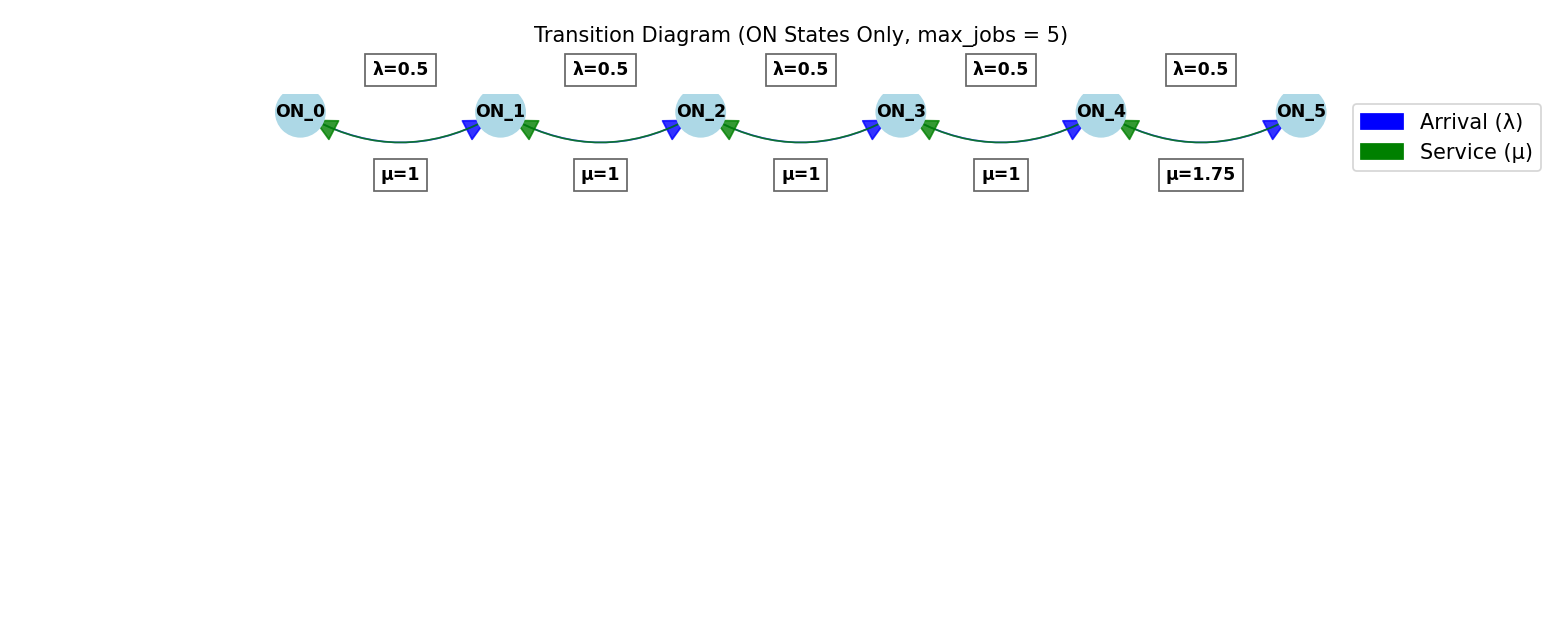

In [24]:
# The same program as beyond, with same setting but will_turn_off = False
def draw_on_only_transition_diagram(max_jobs=5):
    import networkx as nx
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    import warnings
    warnings.filterwarnings("ignore", category=DeprecationWarning)

    G = nx.DiGraph()
    
    arrival_rate = 0.5
    serve_rate = 1
    enhanced_serve_rate = 1.75

    k2 = 4

    on_states = [f'ON_{i}' for i in range(max_jobs + 1)]

    for state in on_states:
        G.add_node(state, color='lightblue', node_type='o')

    for i in range(max_jobs):
        G.add_edge(f'ON_{i}', f'ON_{i + 1}', label=f'λ={arrival_rate}', layer='arrival')

    for i in range(1, max_jobs + 1):
        rate = serve_rate if i <= k2 else enhanced_serve_rate
        G.add_edge(f'ON_{i}', f'ON_{i - 1}', label=f'μ={rate}', layer='service')

    pos = {f'ON_{i}': (i, -0.5) for i in range(max_jobs + 1)}

    plt.figure(figsize=(2.5 * max_jobs, 5))

    plt.subplots_adjust(top=0.85, bottom=0.2)

    node_colors = [G.nodes[node]['color'] for node in G.nodes()]
    node_shapes = [G.nodes[node]['node_type'] for node in G.nodes()]
    
    for shape in set(node_shapes):
        nodelist = [node for node in G.nodes() if G.nodes[node]['node_type'] == shape]
        nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_shape=shape,
                               node_color=[G.nodes[node]['color'] for node in nodelist], node_size=800)

    lambda_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('layer') == 'arrival']
    service_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('layer') == 'service']

    nx.draw_networkx_edges(G, pos, edgelist=lambda_edges, edge_color='blue', arrowstyle='-|>',
                           connectionstyle='arc3,rad=0.3', arrowsize=30, alpha=0.8)

    nx.draw_networkx_edges(G, pos, edgelist=service_edges, edge_color='green', arrowstyle='-|>',
                           connectionstyle='arc3,rad=-0.3', arrowsize=30, alpha=0.8)

    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', verticalalignment='center')

    ax = plt.gca()
    for (u, v, d) in G.edges(data=True):
        label = d.get('label', '')
        x = (pos[u][0] + pos[v][0]) / 2
        y = (pos[u][1] + pos[v][1]) / 2
        y_offset = 0.1 if d['layer'] == 'arrival' else -0.15
        ax.text(x, y + y_offset, label, fontsize=10, fontweight='bold',
                ha='center', va='center', bbox=dict(facecolor='white', alpha=0.6))

    legend_patches = [
        mpatches.Patch(color='blue', label='Arrival (λ)'),
        mpatches.Patch(color='green', label='Service (μ)')
    ]
    plt.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.12, 1), fontsize=12)

    plt.title(f"Transition Diagram (ON States Only, max_jobs = {max_jobs})", pad=30)
    plt.axis('off')
    plt.show()

draw_on_only_transition_diagram(5)

<p><b><a class="anchor" id="sbs3-5">Function 5</a></b>: Customized total cost functions</p>

In [26]:
'''
OPTIONAL: A most complicated total cost function: Single-Threshold and Binary-cost-level function
While the expected amount of jobs is smaller than or equals the given threshold, each waiting job's cost is a constant
And while it exceeds this given threshold, the cost will be doubled
'''

def calculate_total_cost_extra_0(capacity_threshold):
    if expected_jobs > capacity_threshold:
        return capacity_threshold * 2 + (expected_jobs - capacity_threshold) + beta * power_consumption_sum
    else:
        return expected_jobs + beta * power_consumption_sum

print("Expected total cost via using customized total cost functions: ")
calculate_total_cost_extra_0(1)

Expected total cost via using customized total cost functions: 


1.7499999999675555

<a class="anchor" id="bullet4"><h3><b>Section 4</b>: Programs to find the optimized parameters (with the lowest cost)</h3></a> 
<br>
[Back to Menu](#toc)

In [41]:
import numpy as np
import pandas as pd
import time
from itertools import product

# Count this program's running time
start_time = time.time()

def grid_search_cost_0():
    global power_OFF_idle, power_OFF_on, power_ON_reg, power_ON_enhanced
    global k1, will_turn_off
    global cost_plots_0, cost_plots_1
    # Initial parameters set up
    initialize_parameters()
    setup_States()
    exception_handling()
    setup_Transition_Matrix()

    # Initial Parameter (Abstract and not available in the realistic situations)
    best_params = [0, 0, False]
    best_cost = float('inf')
    # Record all parameter groups' cost values (For further plots)
    # cost_plots_0: plots when will_turn_off = False
    # cost_plots_1: plots when will_turn_off = True
    cost_plots_0 = []
    cost_plots_1 = []

    for i_mu, b1 in product(range(1, 501), [True, False]):
        serve_rate = i_mu
        will_turn_off = b1

        setup_Transition_Matrix()
        calculate_Steady_State(False, False)
        calculate_Power_Consumption()
        calculate_Cost(steady_state_df)

        # Add cost values inside the plot list
        if not will_turn_off:
            cost_plots_0.append(total_cost)
        else:
            cost_plots_1.append(total_cost)
            
        # Update the best parameter group once it finds a smaller total cost value
        if total_cost < best_cost:
            best_cost = total_cost
            best_params = [serve_rate]

    return best_params, best_cost

best_params, best_cost = grid_search_cost_0()
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Best Parameters: mu={best_params[0]}")
print(f"Minimum Total Cost: {best_cost}")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

Best Parameters: mu=1
Minimum Total Cost: 0.6416666666587643
Elapsed Time: 103.02 seconds


###### <p><b><a class="anchor" id="sbss4-1-1">Sub-section 1</a></b>- Results' Visualization</p>

In [42]:
# Enable plot interactivity
%matplotlib notebook

<IPython.core.display.Javascript object>


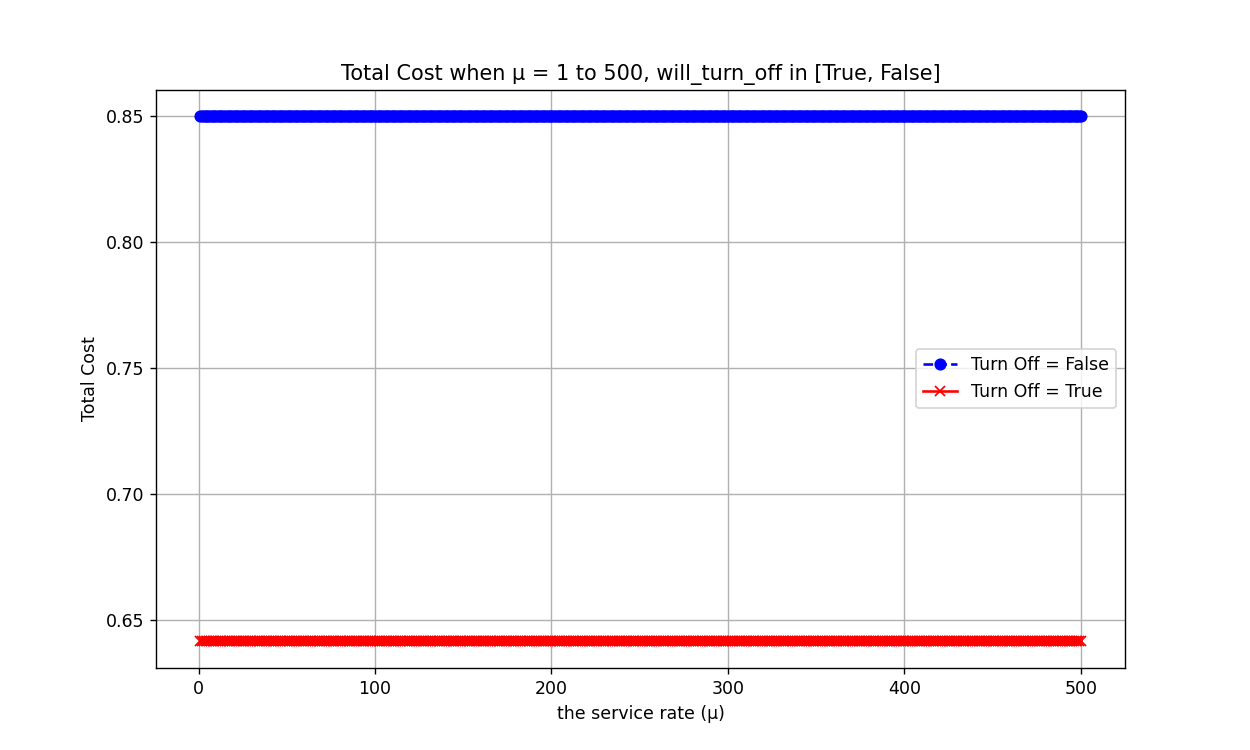

In [43]:
import matplotlib.pyplot as plt
import numpy as np

'''
Plot the above total cost results into visualized diagrams
While the mouse cursor approaches curves, it will show μ values and the power consumption value
REMINDER: DO NOT forget to enable plot interactivity!
'''
def plot_total_cost_0():
    jobs_range = list(range(1, len(cost_plots_0) + 1))

    fig, ax = plt.subplots(figsize=(10, 6))

    line1, = ax.plot(jobs_range, cost_plots_0, label='Turn Off = False', color='blue', linestyle='--', marker='o')
    line2, = ax.plot(jobs_range, cost_plots_1, label='Turn Off = True', color='red', linestyle='-', marker='x')

    ax.set_xlabel('the service rate (μ)')
    ax.set_ylabel('Total Cost')
    ax.set_title('Total Cost when μ = 1 to 500, will_turn_off in [True, False]')
    ax.legend()
    ax.grid(True)

    annot = ax.annotate("", xy=(0,0), xytext=(10,10),
                        textcoords="offset points", bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(ind, line):
        x, y = line.get_data()
        annot.xy = (x[ind["ind"][0]], y[ind["ind"][0]])
        text = f"({x[ind['ind'][0]]:.1f}, {y[ind['ind'][0]]:.8f})"
        annot.set_text(text)
        annot.get_bbox_patch().set_facecolor("yellow")
        annot.set_visible(True)

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            for line in [line1, line2]:
                cont, ind = line.contains(event)
                if cont:
                    update_annot(ind, line)
                    fig.canvas.draw_idle()
                    return
        if vis:
            annot.set_visible(False)
            fig.canvas.draw_idle()

    fig.canvas.mpl_connect("motion_notify_event", hover)

    plt.show()

plot_total_cost_0()

<IPython.core.display.Javascript object>


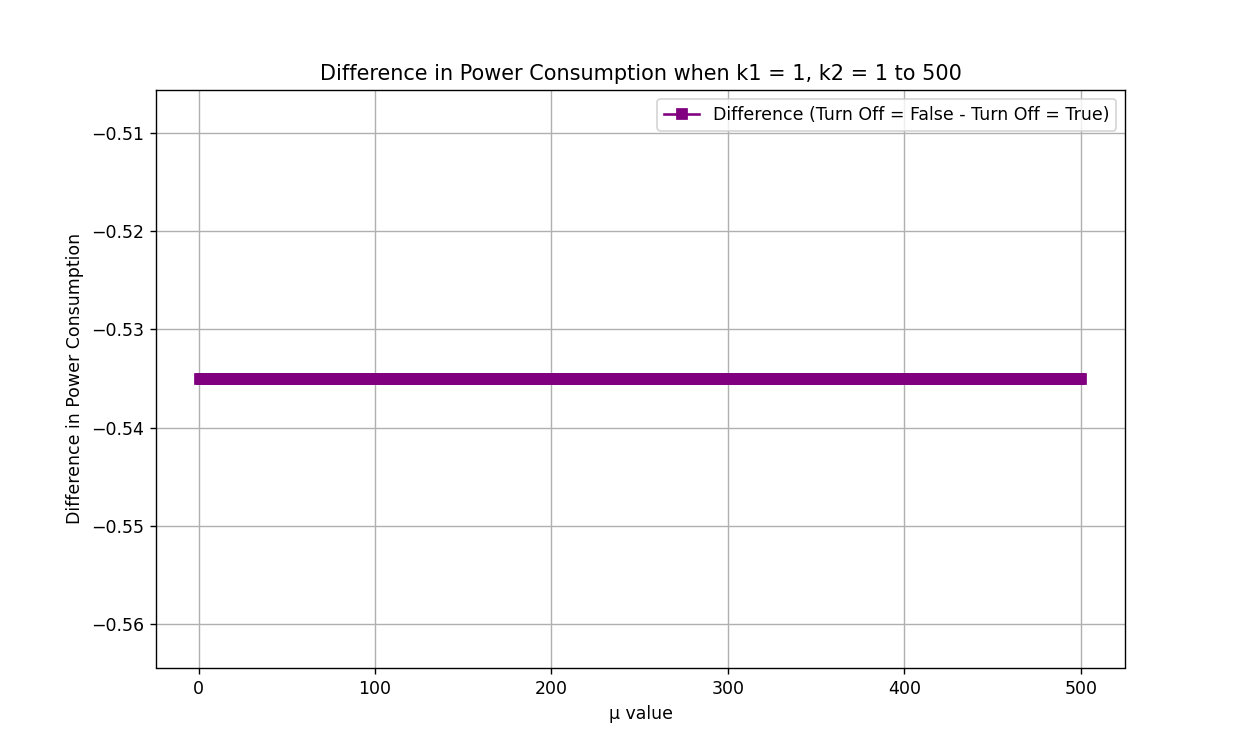

In [39]:
import matplotlib.pyplot as plt
import numpy as np

'''
Calculate both total cost list's differences and plot them on a diagram
While the mouse cursor approaches curves, it will show μ values and the total cost value
REMINDER: DO NOT forget to enable plot interactivity!
'''
def plot_cost_differences_0():
    differences = np.array(cost_plots_0) - np.array(cost_plots_1)
    
    jobs_range = list(range(1, len(differences) + 1))
    fig, ax = plt.subplots(figsize=(10, 6))
    line, = ax.plot(jobs_range, differences, label='Difference (Turn Off = False - Turn Off = True)', color='purple', linestyle='-', marker='s')

    ax.set_xlabel('μ value')
    ax.set_ylabel('Difference in Power Consumption')
    ax.set_title('Difference in Power Consumption when k1 = 1, k2 = 1 to 500')
    ax.legend()
    ax.grid(True)

    annot = ax.annotate("", xy=(0,0), xytext=(10,10),
                        textcoords="offset points", bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(ind, line):
        x, y = line.get_data()
        annot.xy = (x[ind["ind"][0]], y[ind["ind"][0]])
        text = f"({x[ind['ind'][0]]:.1f}, {y[ind['ind'][0]]:.20f})"
        annot.set_text(text)
        annot.get_bbox_patch().set_facecolor("yellow")
        annot.set_visible(True)

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            cont, ind = line.contains(event)
            if cont:
                update_annot(ind, line)
                fig.canvas.draw_idle()
                return
        if vis:
            annot.set_visible(False)
            fig.canvas.draw_idle()

    fig.canvas.mpl_connect("motion_notify_event", hover)

plot_cost_differences_0()